# Modeling

In [1]:
from function import *

In [2]:
# load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.tail()

,Team,Possession,SOT,Shots,Touches,Passes,Tackles,Clearances,Corners,Offsides,Goal,Year,Home,Result
3795,Stoke City,39.0,3,14,510,319,16,29,10,2,1,2016,0,1
3796,Swansea City,65.3,2,12,795,589,17,17,7,1,2,2016,1,1
3797,West Bromwich Albion,34.7,5,16,500,316,18,24,4,0,1,2016,0,0
3798,Watford,32.9,3,6,440,297,20,6,4,0,0,2016,1,0
3799,Manchester City,67.1,9,15,789,620,19,13,5,2,5,2016,0,1


In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_train = train.drop(['Team', 'Result'], axis = 1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(vif_train.values, i) for i in range(vif_train.shape[1])]
vif["features"] = vif_train.columns
vif

,VIF Factor,features
0,136.174014,Possession
1,10.935964,SOT
2,19.660793,Shots
3,1583.093997,Touches
4,732.883603,Passes
5,15.933275,Tackles
6,12.092899,Clearances
7,6.988084,Corners
8,2.705923,Offsides
9,3.579688,Goal


In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_train = train.drop(['Team', 'Result', 'Possession', 'Touches', 'Offsides', 'Year'], axis = 1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(vif_train.values, i) for i in range(vif_train.shape[1])]
vif["features"] = vif_train.columns
vif

,VIF Factor,features
0,10.876718,SOT
1,18.092754,Shots
2,13.362571,Passes
3,8.649483,Tackles
4,5.448460,Clearances
5,6.223119,Corners
6,3.461095,Goal
7,2.199670,Home


### 1. Select columns & Encoding

In [1]:
# Select columns
category = ['Home']
continuous = ['SOT', 'Shots', 'Passes','Tackles', 'Clearances', 'Corners', 'Goal', ]

In [7]:
# make train/test data

train_cols, test_cols = [], []

# category
for cat in category:
    train_tok, test_tok = category_to_ohe(train[cat],test[cat])
    train_cols.append(train_tok)
    test_cols.append(test_tok)    

# continuous
for con in continuous:
    train_cols.append(train[con].values.reshape(len(train),1))
    test_cols.append(test[con].values.reshape(len(test),1))
 

In [8]:
# stack train/test data
X_train = np.hstack(tuple(each for each in train_cols))
X_test = np.hstack(tuple(each for each in test_cols))
y_train = train['Result']

In [9]:
X_train.shape

(3800, 8)

In [10]:
X_test

array([[ 1, 10, 27, ..., 30,  9,  4],
       [ 0,  3,  6, ..., 24,  4,  3],
       [ 1,  2,  6, ..., 39,  3,  0],
       ...,
       [ 0,  9, 16, ..., 17,  4,  4],
       [ 1,  4, 15, ..., 20,  6,  3],
       [ 0,  7, 14, ..., 22,  6,  1]])

In [11]:
y_train.tail()

3795    1
3796    1
3797    0
3798    0
3799    1
Name: Result, dtype: int64

---

### 2. Modeling

 - 조건부 확률 모형 : 각 클래스가 정답일 조건부 확률을 계산

    - 조건부 확률기반 생성모형 : 베이즈 정리를 사용

        - LDA (linear discriminant analysis)
        - QDA (Quadratic Discriminanat Analysis)
        - 나이브 베이지안 (Naive Bayes)
    
    - 조건부 확률기반 판별모형 :  직접 조건부 확률 함수를 추정
    
        - 로지스틱 회귀 (Logistic Regression)
        - 의사결정나무 (Descision Tree)
        - KNN (K Nearest Neighbor)
        
        
- 판별함수 모형 : 경계면을 찾아서 데이터가 어느 위치에 있는지 계산

    - 퍼셉트론 (Perceptron)
    - 서포트 벡터 머신 (Support Vector Machine)
    - 신경망 (Neural Network)  
    
    
- 모형결합 (Ensemble) : 복수의 예측모형을 결합하여 더 나은 성능을 예측하려는 시도

    - 취합 방법론 : 사용할 모형의 집합이 이미 결정되어 있음
        
        - 다수결 (Majority voting)
        - 배깅 (Bagging)
        - 랜덤 포레스트 (Random Forest)
        
    - 부스팅 방법론 : 사용할 모형을 점진적으로 늘림
    
        - 에이다 부스트 (AdaBoost)
        - 그레디언트 부스트 (Gradient Boost)

---

#### 2.1 조건부 확률모형

##### 2.1.1 조건부 확률기반 생성 모형

In [12]:
# LDA (linear discriminant analysis)
model = LinearDiscriminantAnalysis(n_components=3, solver="svd", 
        store_covariance=True).fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[263  16   2]
 [ 49 208  24]
 [134  44  20]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.59      0.94      0.72       281
        Win       0.78      0.74      0.76       281
       Draw       0.43      0.10      0.16       198

avg / total       0.62      0.65      0.59       760



In [13]:
# QDA (Quadratic Discriminanat Analysis)
model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[252  20   9]
 [ 45 212  24]
 [130  41  27]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.59      0.90      0.71       281
        Win       0.78      0.75      0.77       281
       Draw       0.45      0.14      0.21       198

avg / total       0.62      0.65      0.60       760



In [14]:
# Naive bayesian - Multinomial
model = MultinomialNB().fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[201  30  50]
 [ 65 175  41]
 [ 93  56  49]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.56      0.72      0.63       281
        Win       0.67      0.62      0.65       281
       Draw       0.35      0.25      0.29       198

avg / total       0.55      0.56      0.55       760



---

##### 2.1.2 조건부 확률기반 판별모형

In [15]:
# Logistic Regression : 사용 X (종속변수가 이항분포를 따라야함)

In [16]:
# Descision Tree
model = DecisionTreeClassifier(criterion='entropy', 
        max_depth=7, min_samples_leaf=5).fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[233  26  22]
 [ 36 217  28]
 [121  50  27]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.60      0.83      0.69       281
        Win       0.74      0.77      0.76       281
       Draw       0.35      0.14      0.20       198

avg / total       0.59      0.63      0.59       760



In [17]:
# KNN (K Nearest Neighbor)

---

In [18]:
#### 2.2 모형결합 (Ensemble)

In [19]:
##### 2.2.1 취합 방법론

In [20]:
# 다수결 (Majority voting)

# 취합할 모델 생성
model1 = LinearDiscriminantAnalysis(n_components=3, solver="svd", store_covariance=True)
model2 = QuadraticDiscriminantAnalysis()
model3 = GaussianNB()
model4 = MultinomialNB()

# ensemble 생성
ensemble = VotingClassifier(estimators=[('lda', model1), ('qda', model2), ('gnb', model3), ('mul', model4)], 
                            voting='soft', weights=[2, 4, 1, 5])

predict_proba = [c.fit(X_train, y_train).predict_proba(X_test) for c in (model1, model2, model3, model4, ensemble)]

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[4][i])) # ensemble index

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[242  24  15]
 [ 50 199  32]
 [116  47  35]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.59      0.86      0.70       281
        Win       0.74      0.71      0.72       281
       Draw       0.43      0.18      0.25       198

avg / total       0.60      0.63      0.59       760



In [21]:
# 배깅 (Bagging)
model1 = DecisionTreeClassifier().fit(X_train, y_train)
model2 = BaggingClassifier(DecisionTreeClassifier(), bootstrap_features=True, random_state=0).fit(X_train, y_train)
predict_proba = model2.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[210  33  38]
 [ 49 210  22]
 [106  57  35]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.58      0.75      0.65       281
        Win       0.70      0.75      0.72       281
       Draw       0.37      0.18      0.24       198

avg / total       0.57      0.60      0.57       760



In [22]:
# 랜덤포레스트 (RandomForest)
clf = RandomForestClassifier(n_estimators=1000, max_depth=8, min_samples_split = 10, criterion = 'entropy')
model = clf.fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[251  27   3]
 [ 41 235   5]
 [126  57  15]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.60      0.89      0.72       281
        Win       0.74      0.84      0.78       281
       Draw       0.65      0.08      0.14       198

avg / total       0.66      0.66      0.59       760



---

In [23]:
##### 2.2.2 부스팅 방법론

In [24]:
# 에이다 부스트 (Ada Boost)
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, random_state=0), 
                               algorithm="SAMME", n_estimators=300).fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[195  28  58]
 [ 21 213  47]
 [ 76  56  66]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.67      0.69      0.68       281
        Win       0.72      0.76      0.74       281
       Draw       0.39      0.33      0.36       198

avg / total       0.61      0.62      0.62       760



In [25]:
# 그레디언트 부스트 (Gradient Boost)
model = GradientBoostingClassifier(n_estimators=1000, max_depth=5, random_state=0).fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[205  25  51]
 [ 28 216  37]
 [101  52  45]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.61      0.73      0.67       281
        Win       0.74      0.77      0.75       281
       Draw       0.34      0.23      0.27       198

avg / total       0.59      0.61      0.60       760



In [26]:
# XG boost
model = xgboost.XGBClassifier(n_estimators=500, max_depth=2).fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[243  24  14]
 [ 36 233  12]
 [108  57  33]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.63      0.86      0.73       281
        Win       0.74      0.83      0.78       281
       Draw       0.56      0.17      0.26       198

avg / total       0.65      0.67      0.63       760



---

In [27]:
#### 2.3 판별함수 모형

In [28]:
# 퍼셉트론 (Perceptron) - perceptron
model = Perceptron(max_iter=500, eta0=0.1, random_state=1).fit(X_train, y_train)
predict_proba = model.predict(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[281   0   0]
 [281   0   0]
 [198   0   0]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.37      1.00      0.54       281
        Win       0.00      0.00      0.00       281
       Draw       0.00      0.00      0.00       198

avg / total       0.14      0.37      0.20       760



/anaconda3/envs/practice/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
# 퍼셉트론 (Perceptron) - SGD
model = SGDClassifier(loss="hinge", max_iter=3, random_state=1).fit(X_train, y_train)
predict_proba = model.predict(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[281   0   0]
 [281   0   0]
 [198   0   0]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.37      1.00      0.54       281
        Win       0.00      0.00      0.00       281
       Draw       0.00      0.00      0.00       198

avg / total       0.14      0.37      0.20       760



/anaconda3/envs/practice/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
# 서포트 벡터 머신 (Support Vector Machine) - linear
model = SVC(kernel='linear').fit(X_train, y_train)
predict_proba = model.predict(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[281   0   0]
 [281   0   0]
 [198   0   0]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.37      1.00      0.54       281
        Win       0.00      0.00      0.00       281
       Draw       0.00      0.00      0.00       198

avg / total       0.14      0.37      0.20       760



/anaconda3/envs/practice/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
# 서포트 벡터 머신 (Support Vector Machine) - 다항 커널 (Polynomial Kernel)
model = SVC(kernel="poly", degree=2, gamma=1, coef0=0).fit(X_train, y_train)
predict_proba = model.predict(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[281   0   0]
 [281   0   0]
 [198   0   0]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.37      1.00      0.54       281
        Win       0.00      0.00      0.00       281
       Draw       0.00      0.00      0.00       198

avg / total       0.14      0.37      0.20       760



/anaconda3/envs/practice/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
# 서포트 벡터 머신 (Support Vector Machine) - RBF(Radial Basis Function)
model = SVC(kernel="rbf").fit(X_train, y_train)
predict_proba = model.predict(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[281   0   0]
 [281   0   0]
 [198   0   0]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.37      1.00      0.54       281
        Win       0.00      0.00      0.00       281
       Draw       0.00      0.00      0.00       198

avg / total       0.14      0.37      0.20       760



/anaconda3/envs/practice/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
# 서포트 벡터 머신 (Support Vector Machine) - 시그모이드 커널 (Sigmoid Kernel)
model = SVC(kernel="sigmoid", gamma=2, coef0=2).fit(X_train, y_train)
predict_proba = model.predict(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[281   0   0]
 [281   0   0]
 [198   0   0]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.37      1.00      0.54       281
        Win       0.00      0.00      0.00       281
       Draw       0.00      0.00      0.00       198

avg / total       0.14      0.37      0.20       760



/anaconda3/envs/practice/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
# 신경망 (Neural Network)

---

### 3. Grid Search / Cross Validation

In [36]:
# choose parameter
param_grid = [
    {'n_estimators' : [10, 50, 100, 200, 300, 500, 1000], 'max_depth' : [2, 4, 6, 8, 10], 
     'min_samples_split' : [5, 10, 15, 20, 30]}]

model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv = 5, return_train_score = True).fit(X_train, y_train)

print('Best Parameter :\n\n', grid_search.best_params_)

Best Parameter :

 {'max_depth': 6, 'min_samples_split': 30, 'n_estimators': 50}


In [37]:
# validation score
clf = RandomForestClassifier(max_depth = 6, min_samples_split = 15, n_estimators = 100).fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv= 10)
print('Corss Validation Score :\n\n', scores)

Corss Validation Score :

 [0.62368421 0.64473684 0.63684211 0.66842105 0.62894737 0.62368421
 0.62894737 0.63157895 0.66578947 0.67368421]


In [39]:
df = pd.DataFrame()
df['Feature'] = ['Goal', 'SOT', 'Clearances', 'Passes', 'Shots', 'Home', 'Tackles', 'Corners']
df['Importance'] = grid_search.best_estimator_.feature_importances_

In [41]:
labels = ['Goal', 'SOT', 'Clearances', 'Passes', 'Shots', 'Home', 'Tackles', 'Corners']

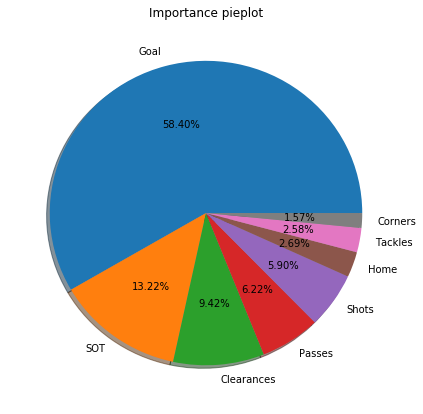

In [42]:
plt.figure(figsize=(7, 7))

plt.pie(df['Importance'], labels = labels, autopct='%1.2f%%', shadow = True, explode = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0))
plt.title('Importance pieplot')

plt.show()

In [56]:
# 랜덤포레스트 (RandomForest)
clf = RandomForestClassifier(max_depth = 6, min_samples_split = 30, n_estimators = 50, criterion = 'entropy')
model = clf.fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[256  25   0]
 [ 42 237   2]
 [133  59   6]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.59      0.91      0.72       281
        Win       0.74      0.84      0.79       281
       Draw       0.75      0.03      0.06       198

avg / total       0.69      0.66      0.57       760



### 4. Evaluation

In [58]:
# make binarize
y0 = []
for i in range(len(y_true)):
    if y_true[i] == 0 :
        y0.append(1) # y가 0이면 1
    else:
        y0.append(0) # y가 0이 아니면 0
    
y1 = []
for i in range(len(y_true)):
    if y_true[i] == 1 :
        y1.append(1) # y가 1이면 1
    else:
        y1.append(0) # y가 1이 아니면 0
        
y2 = []
for i in range(len(y_true)):
    if y_true[i] == 2 :
        y2.append(1) # y가 2이면 1
    else:
        y2.append(0) # y가 2가 아니면 0   

In [59]:
# make model
fpr1, tpr1, thresholds1 = roc_curve(y0, model.predict_proba(X_test)[:, 0])
fpr2, tpr2, thresholds2 = roc_curve(y1, model.predict_proba(X_test)[:, 1])
fpr3, tpr3, thresholds3 = roc_curve(y2, model.predict_proba(X_test)[:, 2])

ROC Curve :



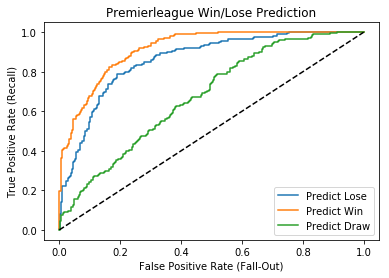

AUC Score :

 0.8595829092340954 0.9154748549394869 0.6756623171213918


In [60]:
# ROC curve
print('ROC Curve :\n')
plt.plot(fpr1, tpr1, label= 'Predict Lose')
plt.plot(fpr2, tpr2, label= 'Predict Win')
plt.plot(fpr3, tpr3, label= 'Predict Draw')
plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Premierleague Win/Lose Prediction')
plt.show()

print('AUC Score :\n\n', auc(fpr1, tpr1), auc(fpr2, tpr2), auc(fpr3, tpr3))